<a href="https://colab.research.google.com/github/KwokHing/SHAP-XAI-Demo/blob/main/Explainable_AI_Graded_Hands_on_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Overview**

Throughout this template, you will be performing specific well-defined tasks that’ll strengthen your concepts in Explainable AI. We will be using the Breast Cancer Dataset and here is a brief context about the same:

Breast cancer is a type of cancer that starts in the breast. Cancer starts when cells begin to grow out of control. Breast cancer cells usually form a tumor that can often be seen on an x-ray or felt as a lump. Breast cancer occurs almost entirely in women, but men can get breast cancer, too.
A benign tumor is a tumor that does not invade its surrounding tissue or spread around the body. A malignant tumor is a tumor that may invade its surrounding tissue or spread around the body.

As part of the assignment, you will have to accomplish the below tasks.

**Author:** Ayoub Berdeddouch

###**Dataset**

Dataset Link: https://raw.githubusercontent.com/dphi-official/Datasets/master/breast_cancer/Training_set_breastcancer.csv

**About the dataset:**

Different features related to the breast are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe the characteristics of the cell nuclei present in the image.


* id: Id number
* diagnosis: Cancer is Malignant or Benign (M = malignant, B = benign) - target variable

Other 20 features contain information about following 10 real valued features

* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values) 
* perimeter 
* area 
* smoothness (local variation in radius lengths) 
* compactness (perimeter^2 / area - 1.0) 
* concavity (severity of concave portions of the contour) 
* concave points (number of concave portions of the contour) 
* symmetry  
* fractal dimension ("coastline approximation" - 1)

# Task 1

## Import Necessary Libraries

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 5.1 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

import shap

# load JS visualization code to notebook. Without this, the SHAP plots won't be displayed
shap.initjs()

## Load the data
Display the first 5 rows of the data after loading.

In [ ]:
# getting data and labels from the dataset
df = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/breast_cancer/Training_set_breastcancer.csv')
df.head()

id  radius_mean  ...  fractal_dimension_worst  diagnosis
0    914102        13.16  ...                  0.07429          B
1     91858        11.75  ...                  0.07757          B
2  88466802        10.65  ...                  0.08147          B
3   9111843        12.00  ...                  0.08194          B
4  84862001        16.13  ...                  0.11420          M

[5 rows x 32 columns]

## Perform Basic Exploratory Data Analysis (EDA)

#### Viewing the Class Labels Distribution

Let’s view the distribution of people with cancer diagnosis (M or B) which are the class labels that we want to predict.

In [ ]:
# viewing the distribution of class labels
df['diagnosis'].value_counts()

B    250
M    148
Name: diagnosis, dtype: int64

#### Checking the Data Types 



In [ ]:
# viewing the data types of each column (feature)
df.dtypes

id                           int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

In [ ]:
df['diagnosis'].replace({'B': 0, "M": 1}, inplace=True)

#### Dropping 'id' column

Using common knowledge, id column serves no purpose in predicting the class, thus we can drop the id column.

In [ ]:
# dropping 'id' column (feature)
df = df.drop('id', 1)

## Split the data into Train and Test Sets
The train to test ratio should be 80:20 and the random_state should be 0.

In [ ]:
# split into input and output elements
X, y = df.loc[:, df.columns != 'diagnosis'], df['diagnosis']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape)
X_train.head()

(318, 30) (80, 30)


radius_mean  texture_mean  ...  symmetry_worst  fractal_dimension_worst
64         11.62         18.18  ...          0.2660                  0.09270
55         19.55         28.77  ...          0.2818                  0.10050
317        13.14         20.74  ...          0.2563                  0.08174
102        16.78         18.80  ...          0.2810                  0.07228
358        19.53         32.47  ...          0.2713                  0.07568

[5 rows x 30 columns]

# Task 2

## Use Random Forest Machine Learning Model for prediction

In [ ]:
# importing RandomForest model from sklearn library
from sklearn.ensemble import RandomForestClassifier

# creating a RF Classifier
rf = RandomForestClassifier()

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
               
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 400}

## Evaluate the model using Accuracy Score

In [ ]:
#rf_tuned = RandomForestClassifier(bootstrap=True, max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=2000)
rf_tuned = rf_random.best_estimator_

# Fit with best random search model
rf_tuned.fit(X_train,y_train)

# predict
predictions = rf_tuned.predict(X_test)

In [ ]:
# view accuracy, confusion matrix and F1 score
acc = accuracy_score(y_test, predictions)
print("Accuracy: %.3f" % acc)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.950
[[42  0]
 [ 4 34]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        42
           1       1.00      0.89      0.94        38

    accuracy                           0.95        80
   macro avg       0.96      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



In [ ]:
predictions[0:5]

array([1, 0, 1, 0, 0])

# Task 3: Explaining the model with SHAP and Lime.

##  Use a SHAP Explainer to derive SHAP Values for the random forest ml model.



In [ ]:
# creating an explainer for our model
explainer = shap.TreeExplainer(rf_tuned)

# finding out the shap values using the explainer
shap_values = explainer.shap_values(X_test)

# Expected/Base/Reference value = the value that would be predicted if we didn’t know any features of the current output”
print('Expected Value:', explainer.expected_value)

# displaying the first 5 rows of the shap values table
pd.DataFrame(shap_values[1]).head()

Expected Value: [0.65543239 0.34456761]


0         1         2   ...        27        28        29
0 -0.004958  0.019210  0.005311  ...  0.071717  0.006627  0.009846
1 -0.014099 -0.002416 -0.018526  ... -0.027488 -0.001246 -0.002210
2 -0.017312  0.001644 -0.020754  ... -0.014466 -0.000167 -0.001090
3 -0.014567 -0.013892 -0.016485  ... -0.025599 -0.002576 -0.002349
4 -0.012080 -0.003942 -0.017174  ... -0.027228 -0.000252 -0.003013

[5 rows x 30 columns]

## Write your inferences from the generated plot.

The shap_values object is a list with two arrays. The first array is the SHAP values for a negative outcome, whereas the second array is the list of SHAP values for the positive outcome. We typically think about predictions in terms of the prediction of a positive outcome, so we'll pull out SHAP values for positive outcomes using *shap_values[1]*. <br/><br/>
Also, the Expected Value: 0.34591195 being displayed above will be used as the base value throughout all the visualizations. The values above this base value will be put into class 1 (malignant tumor) wherras the values below it will be put into class 0 (benign tumor)

# Task 4

## Plot a SHAP force plot for the first row of test data.

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:])

In [ ]:
X_train.mean()

radius_mean                 13.982824
texture_mean                19.350472
perimeter_mean              90.999591
area_mean                  645.931761
smoothness_mean              0.095955
compactness_mean             0.102389
concavity_mean               0.086571
concave points_mean          0.046616
symmetry_mean                0.180609
fractal_dimension_mean       0.062933
radius_se                    0.406402
texture_se                   1.212970
perimeter_se                 2.884900
area_se                     40.664362
smoothness_se                0.007201
compactness_se               0.025324
concavity_se                 0.032520
concave points_se            0.011811
symmetry_se                  0.020548
fractal_dimension_se         0.003787
radius_worst                16.039280
texture_worst               25.527642
perimeter_worst            105.737642
area_worst                 861.438679
smoothness_worst             0.132273
compactness_worst            0.247626
concavity_wo

## Write your inferences from the generated plot.

The final value of 0.7 (displayed in bold) is higher than the base value (0.35). Thus, this observation is classified as class 1 (malignant tumor).

The visualisation shows each features contributing to pushing the model output from the base value (the average model output over the training dataset we passed) to the actual model output.

**Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.**

We can that the features displayed in blue are features contributing to the prediction of the observation to be class 0 (benign tumor).

We can see that the values of the features in red are higher than the average values in X_train thus pushing the final value higher i.e perimeter_worst value of 116.2 is higher than the X_train mean value of 105.7, vice versa the values of the features in blue are lower than the X_train average values.

# Task 5

## Plot a SHAP force plot for all the rows of the data

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)

## Write your inferences from the generated plot.

The default visualization(sample order by similarity i.e putting the observations having the most similar features together) shows:

* Most of the predicted benign tumor 100 have lower radius_worst and/or area_worst values

* Whereas, most of the predicted malignant tumor has high radius_worst, perimeter_worst and area_worst values



# Task 6

## Plot a SHAP summary plot using all the features in the data

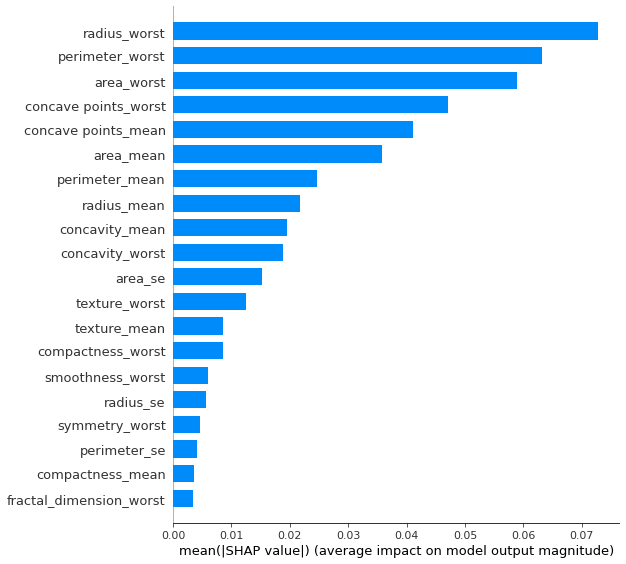

In [ ]:
shap.initjs()
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

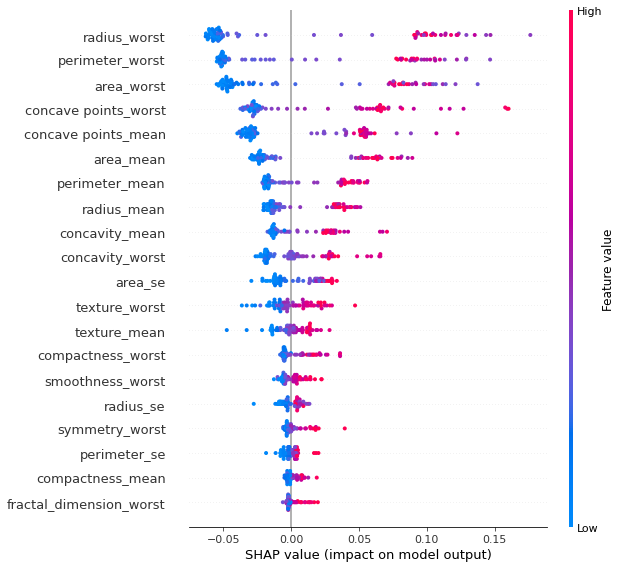

In [ ]:
shap.initjs()
shap.summary_plot(shap_values[1], X_test)

## Write your inferences from the generated plot.

From the above simple bar chart, we observe that radius_worst, perimeter_worst and area_worst features are the top 3 important features determining the tumour diagnosis. 

On the other hand, fractal_dimension_worst, compactness_mean and symmetry_worst are the least important features in determining the tumour diagnosis.

# Task 7

##Plot a SHAP dependence plot using all features in the data

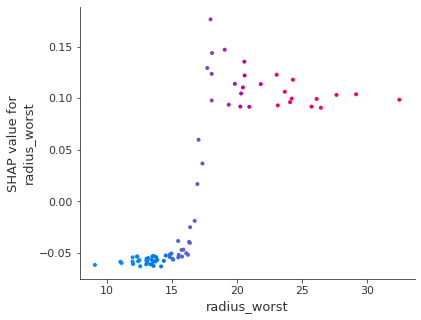

In [ ]:
shap.initjs()
shap.dependence_plot(ind='radius_worst', interaction_index='radius_worst',
                     shap_values=shap_values[1], 
                     features=X_test)

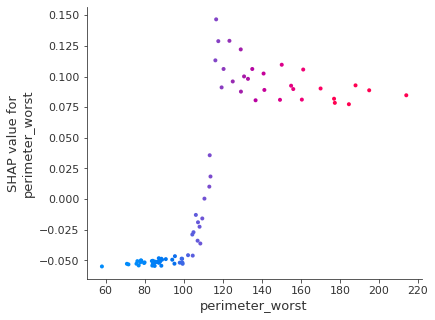

In [ ]:
shap.initjs()
shap.dependence_plot(ind='perimeter_worst', interaction_index='perimeter_worst',
                     shap_values=shap_values[1], 
                     features=X_test)

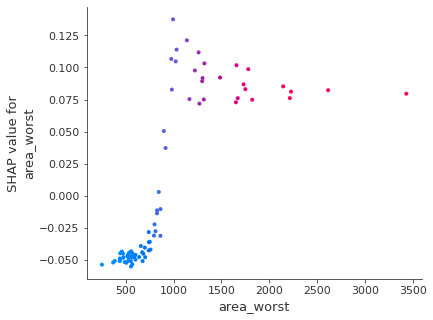

In [ ]:
shap.initjs()
shap.dependence_plot(ind='area_worst', interaction_index='area_worst',
                     shap_values=shap_values[1], 
                     features=X_test)

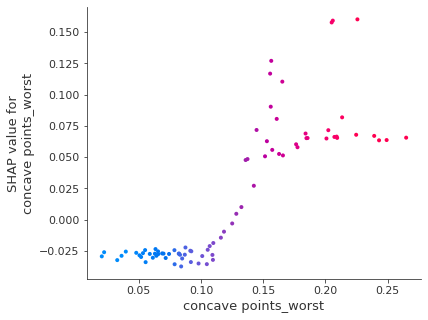

In [ ]:
shap.initjs()
shap.dependence_plot(ind='concave points_worst', interaction_index='concave points_worst',
                     shap_values=shap_values[1], 
                     features=X_test)

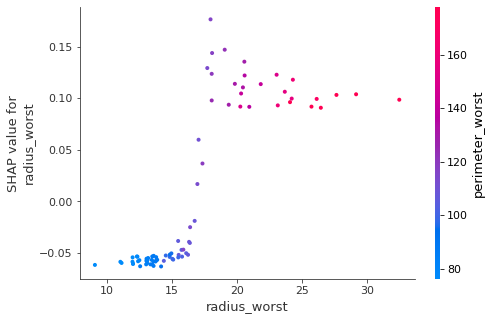

In [ ]:
shap.initjs()
shap.dependence_plot(ind='radius_worst', interaction_index='perimeter_worst',
                     shap_values=shap_values[1], 
                     features=X_test)

## Write your inferences from the generated plot.

It was observed that higher radius_worst, perimeter_worst, or area_worst values have significantly higher shap value, pushing the model’s prediction decisions to say that these records are more likely to be malignant tumor instead of benign.

# Task 8 (Optional)

## Do anything and everything with SHAP
This is the section to explore what more you can do with SHAP. Create some meaningful visualisations and write down what you can infer from them. 

Who knows, this section might carry some bonus points.